### OpenAI Gym

https://www.gymlibrary.dev/

### Credits
This lecture is built on work by:
- Leonardo A. Espinosa Ph.D.
- Andrej Scherbakov-Parland, M.Sc.

### Bibliography:

For this lecture:

* Sutton, Richard S., and Andrew G. Barto. Reinforcement learning: An introduction. Ch 1. MIT press, 2020.
http://incompleteideas.net/book/RLbook2020.pdf

* AlphaGo the movie https://www.youtube.com/watch?v=WXuK6gekU1Y

* Yuxi Li. Deep Reinforcement Learning, 2018.
https://arxiv.org/abs/1810.06339


General:

* Introduction to Reinforcement Learning with David Silver - https://deepmind.com/learning-resources/-introduction-reinforcement-learning-david-silver

* Bostrom, Nick. Superintelligence. Dunod, 2017.

In [2]:
# Install packages
!pip install gym[all] seaborn pandas

# VS build tools for C++ 14.00 or greater for OpenAI Gym on Windows
#
# Download link:
# https://visualstudio.microsoft.com/visual-cpp-build-tools/
#
# Tested on Windows 10, Python 3.10


  Using cached gym-0.26.2.tar.gz (721 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached gym_notices-0.0.8-py3-none-any.whl (3.0 kB)
  Using cached pytest-7.0.1-py3-none-any.whl (296 kB)
  Using cached mujoco_py-2.1.2.14-py3-none-any.whl (2.4 MB)
  Using cached opencv_python-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (60.9 MB)
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Using cached moviepy-1.0.3.tar.gz (388 kB)
  Preparing metadata (setup.py) ... done
  Using cached swig-4.1.0-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.8 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.1 MB/s eta 0:00:0031m13.7 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 37.4 MB/s eta 0:00:00m eta 0:00:010:0101
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 45.6 MB/s eta 0:00:00

### Lunar Lander

In [3]:
import gym
env = gym.make("LunarLander-v2", render_mode="human")
env.action_space.seed(42)

observation, info = env.reset(seed=42)

for _ in range(500):
    observation, reward, terminated, truncated, info = env.step(env.action_space.sample())

    if terminated or truncated:
        observation, info = env.reset()

env.close()

# Agenten

In [4]:
# Sketching the agent

import numpy as np

class Agent_v0(object):
    def __init__(self):
        self.stateHistory = None

    def chooseAction(self):
        pass
    
    def updateStateHistory(self):
        pass
    
    def learn(self):
        pass

# Miljön

In [6]:
# defining our environment

# 6 x 6 matrix
# Robot enters at (0,0) - top left and Exit at (5,5) - bottom right.
# Numpy array 0s are empty, 1s are the walls (X), 2 is robot (R).

class Maze_v0(object):
    def __init__(self):
        self.maze = np.zeros((6,6))
        self.maze[5,:5] = 1
        self.maze[:4,5] = 1
        self.maze[2,2:] = 1
        self.maze[3,2] = 1
        self.maze[0,0] = 2
        self.robotPosition = (0,0)
        
    def isAllowedMove(self, state, action):
        pass

    def updateMaze(self, action):
        pass

    def isGameOver(self, state):
        pass

    def printMaze(self):
        print('------------------------------------')
        for row in self.maze:
            for col in row:
                if col==0:
                    print('-',end='\t')
                elif col==1:
                    print('X',end='\t')
                elif col==2:
                    print('R',end='\t')
            print('\n')
        print('-------------------------------------')

    def get_matrix(self):
        return self.maze

In [7]:
# Visa miljön

maze = Maze_v0()
maze.printMaze()

------------------------------------
R	-	-	-	-	X	

-	-	-	-	-	X	

-	-	X	X	X	X	

-	-	X	-	-	X	

-	-	-	-	-	-	

X	X	X	X	X	-	

-------------------------------------


# Render for humans please!

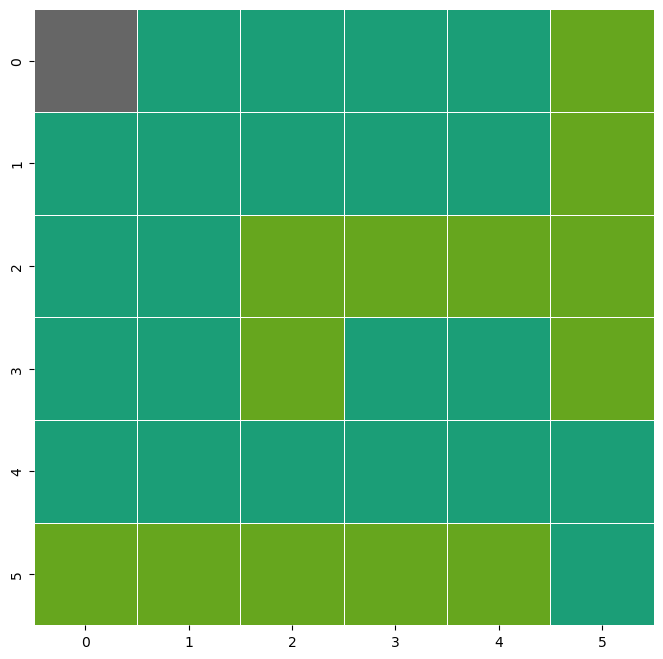

In [8]:
# make a much nicer plot using seaborn -> unnecessary :)

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(8, 8))
a = maze.get_matrix()
plt.show(sns.heatmap(a,cmap="Dark2",cbar=False,linewidths=.5))

# Final version of the Agent
Från vår agent skiss tidigare gör vi:

- actionSpace Dictionary
    - Hur den får röra sig (x,y) kordinater
- chooseAction function()    
    - Möjligheten att välja en handling
    - randomFactor! Explore vs Exploit
- updateStateHistory function()

In [9]:
# Final version for the agent class.

import numpy as np 

actionSpace = {'U': (-1,0), 'D': (1,0), 'L': (0,-1), 'R': (0,1)}     # Action space, actions as movements

class Agent(object):                                                 # define my agent class    
    def __init__(self, maze, alpha=0.15, randomFactor=0.2):          # default random vales 80% exploting / 20% exploring. alpha
        self.stateHistory = [((0,0), 0)]                             # state, reward pairs. 
        self.G = {}                                                  # present value of expected future rewards      
        self.randomFactor = randomFactor
        self.alpha = alpha   
        self.initReward(maze.allowedStates)  

    def chooseAction(self, state, allowedMoves):                    # encoding physics into the environment
        maxG = -10e15                                               # basis for comparison in the first move
        nextMove = None 
        randomN = np.random.random()                                # pick a number from a random distribution, compares with random factor
        if randomN < self.randomFactor:
            nextMove = np.random.choice(allowedMoves)          
        else:            
            for action in allowedMoves:                              # iterate over the allowed moves and look for the
                newState = tuple([sum(x) for x in zip(state, actionSpace[action])]) # approximation of the  reward for                                                        
                if self.G[newState] >= maxG:                         # the new state, and then we compare it with our
                    maxG = self.G[newState]                          # best known reward
                    nextMove = action                                # if it is good we save it as our best reward and pick
        return nextMove                                              # the next move as the respective action.

    def initReward(self, allowedStates):
        for state in allowedStates:     
            self.G[state] = np.random.uniform(low=-1.0, high=-0.1)
            
            
    def updateStateHistory(self, state, reward):           # To update our stateHistory, we want to pass in the new state
        self.stateHistory.append((state, reward))          # and reward, and we simply use the append function
                                                           # to append the state reward tuple to our list.         


    def learn(self):    #this is called at the end of the episode when the agent has finished running the maze. 
        target = 0      # we only learn when we beat the maze

        for prev, reward in reversed(self.stateHistory):                    
            self.G[prev] = self.G[prev] + self.alpha * (target - self.G[prev])            
            target += reward

        self.stateHistory = []
        self.randomFactor -= 10e-5                        # decrease the random factor at every step, gradually go from exploration to exploitation.

        

    def printG(self):
        for i in range(6):            
            for j in range(6):
                if (i,j) in self.G.keys():
                    print('%.6f' % self.G[(i,j)], end='\t')
                else:
                    print('X', end='\t\t')
            print('\n')



# Final version of the Environment

Vi modifierar vår vakra seaborn labyrint med de sista detaljerna

- Ingen tunnel effekt, vi följer fysikens lagar och ser till att agenten inte kan röra sig utanför "sin" värld eller gå in/igenom väggar.
- Vi sätter in tillåtna handlingar (actionSpace) i miljön

Detta är ett av de enklare sätten att lösa labyrinten, dock abosolut inte det mest effektiva.

In [10]:
# final version for the environment, aka Maze
# Define allowed moves, construct allowed states, game over function, get state, print maze and update maze.

# Aditional functionalities
# - Keep track of the number of steps
# - Check game over.
# - Get state / reward.
# - Print the maze

import numpy as np
actionSpace = {'U': (-1,0), 'D': (1,0), 'L': (0,-1), 'R': (0,1)}  # action space

class Maze(object):
    def __init__(self):        
        self.maze = np.zeros((6,6)) # 6x6 maze - exit at 5,5
        self.maze[5, :5] = 1 
        self.maze[:4, 5] = 1
        self.maze[2, 2:] = 1
        self.maze[3,2] = 1
        self.maze[0,0] = 2
        self.robotPosition = (0,0)
        self.steps = 0                                          # initial steps to zero
        self.constructAllowedStates()                           # construct the allowed states

    def printMaze(self):
        print('------------------------------------------')
        for row in self.maze:      
            for col in row:
                if col == 0:                                    # empty spaces
                    print('', end='\t')
                elif col == 1:                                  # walls
                    print('X', end='\t')
                elif col == 2:                                  # robot
                    print('R', end='\t')                    
            print('\n')
        print('------------------------------------------')       
    
    def isAllowedMove(self, state, action):
        y, x = state
        y += actionSpace[action][0]                             # extract the coordinates from the action space
        x += actionSpace[action][1]
        if y < 0 or x < 0 or y > 5 or x > 5:                    # check if the move is allowed, inside the maze
            return False

        if self.maze[y,x] == 0 or self.maze[y,x] == 2:          #check if the new state is zero (or the actual position of the robot, because not moving is valid)
            return True
        else:
            return False

    def constructAllowedStates(self):                           # construct a dictionary and loop over the maze
        allowedStates= {}
        for y, row in enumerate(self.maze):
            for x, col in enumerate(row):                
                if self.maze[(y,x)] != 1:                       # It goes space by space checking if the actions are allowed, if yes it appended to allowed states dictionary
                    allowedStates[(y,x)] = []
                    for action in actionSpace:
                        if self.isAllowedMove((y,x), action):
                            allowedStates[(y,x)].append(action)
        self.allowedStates = allowedStates

    def updateMaze(self, action):                              
        y,x = self.robotPosition
        self.maze[y,x] = 0                                       # Get the current position of the robot and set to 0
        y += actionSpace[action][0]                              # read the coordinates from the action space diccionary 
        x += actionSpace[action][1]               
        self.robotPosition = (y,x)                               # updates the position of the robot
        self.maze[y,x] = 2                                       # update the mze
        self.steps += 1                                          # adds a new step

    def isGameOver(self):                                        # Check if the position is in the exit.
        if self.robotPosition == (5,5):
            return True
        else:
            return False
    
    def getStateAndReward(self):                                 
        reward = self.giveReward()
        return self.robotPosition, reward

    def giveReward(self):                                        # Gives the reward of 0 if the robots is in the exit.
        if self.robotPosition == (5,5):
            return 0
        else:
            return -1
        
    def get_matrix(self):
        return self.maze

## Vad har vi gjort?
Att lösa labyrinten med vår agent är en god utgångspunkt till svårare problem.

Vi har täckt de väsentliga begreppen för förstärkt lärande (*RL*) och skapat något som lär sig från de första principerna.

Allt agenter egentligen behöver är ett internt minne av tillstånds- (state-) och belöningsparen (rewardpairs); en uppskattning av de förväntade framtida belöningarna (*G*) och någon mekanism för att då och då välja slumpmässiga åtgärder för att testa dess modell av världen (*Explore vs Exploit*).

# Main function to use our Agent + Maze from above


- Två agenter
- 5000 matcher
- Prova 𝛼 = 0.1 och  𝛼 =0.99
- Vi väljer en slumpmässig faktor av 0.2.
- Vi ritar ut hur många steg det tar varje robot att klara en episod.

In [11]:
# Let's create our main function

import numpy as np
import matplotlib.pyplot as plt 

maze = Maze()
robot = Agent(maze, alpha=0.1, randomFactor=0.2)
moveHistory = []      # keep track of the number of moves.
for i in range(5000): # number of games
    if i % 1000 == 0:
        print(i)      # just to know is running.
    while not maze.isGameOver():     # while the game is not over
        state, _ = maze.getStateAndReward()   # gets state and reward
        action = robot.chooseAction(state, maze.allowedStates[state]) # update the actions
        maze.updateMaze(action)
        state, reward = maze.getStateAndReward()
        robot.updateStateHistory(state, reward)
        if maze.steps > 1000:                  # cut prematurely to avoid infinite looping
            maze.robotPosition = (5,5)
    robot.learn()                              # learns
    moveHistory.append(maze.steps)             # keep tracking of steps
    maze = Maze()                              # resets the maze but not the agent.

maze = Maze()
robot = Agent(maze, alpha=0.99, randomFactor=0.2)
moveHistory2 = []
for i in range(5000):
    if i % 1000 == 0:
        print(i)
    while not maze.isGameOver():
        state, _ = maze.getStateAndReward()
        action = robot.chooseAction(state, maze.allowedStates[state])
        maze.updateMaze(action)
        state, reward = maze.getStateAndReward()
        robot.updateStateHistory(state, reward)
        if maze.steps > 1000:
            maze.robotPosition = (5,5)            
    robot.learn()
    moveHistory2.append(maze.steps)
    maze = Maze()

0
1000
2000
3000
4000
0
1000
2000
3000
4000


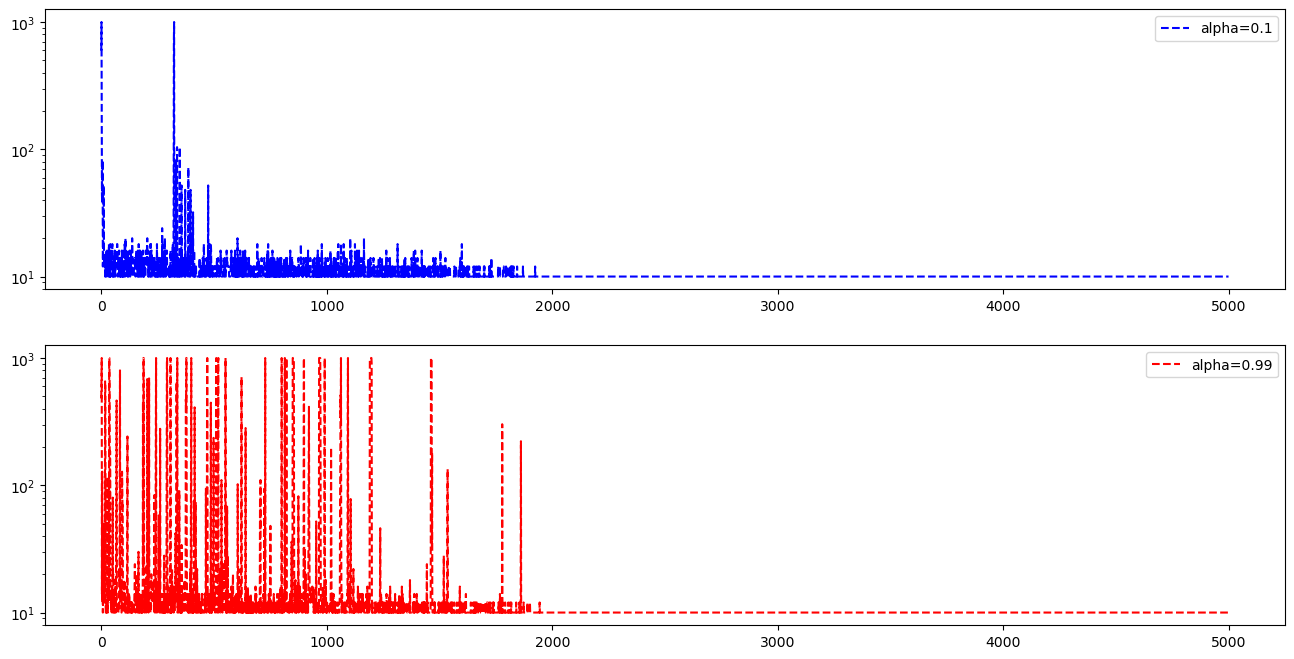

In [12]:
# A plot to show how our agent is doing!
plt.figure(figsize=(16, 8))
plt.subplot(211)
plt.semilogy(moveHistory, 'b--')
plt.legend(['alpha=0.1'])
plt.subplot(212)
plt.semilogy(moveHistory2, 'r--')
plt.legend(['alpha=0.99'])
plt.show()